# Recreating @idatadrew's implementation which can be found [here](https://public.tableau.com/views/NHL-ChangeinAverageAttendanceperGame/NHL-ChangeinAverageAttendanceperGame?:embed=y&:display_count=yes&publish=yes&:toolbar=no&:showVizHome=no).

## What is the % change in average attendance per game for NHL teams compared to the 2000-01 season?

In [1]:
import math
import numpy as np 
import pandas as pd
from PIL import Image

import matplotlib
from matplotlib.backends.backend_pgf import FigureCanvasPgf
matplotlib.backend_bases.register_backend('pdf', FigureCanvasPgf)

from matplotlib import rc
rc('text',usetex=True)
rc('text.latex', preamble=r'\usepackage{xcolor}')
rc('pgf', preamble=r'\usepackage{xcolor}', rcfonts=False)

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None # surpress is copy warning

In [2]:
df = pd.read_csv('./NHL Attendance.csv')
df.columns

Index(['SEASON', 'RANK', 'TEAM', 'HOME GAMES', ' HOME ATTENDANCE ',
       'ROAD GAMES', ' ROAD ATTENDANCE ', 'TOTAL GAMES', ' TOTAL ATTENDANCE '],
      dtype='object')

In [3]:
df = df.query('TEAM != "Vegas"')
#print(df.groupby('TEAM')['SEASON'].count())

In [4]:
def clean_numeric_column(df, column_name):
    series = df[column_name].str.strip()
    series = series.str.replace(',', '')
    series = pd.to_numeric(series)
    df[column_name] = series
    return df

def format_percent(season_one, season_two):
    percent = season_one / season_two;
    percent = percent - 1
    return round(percent * 100, 1)

def calculate_percent_change(current_attendance, team, df):
    row = df.query('SEASON == "2000-01" and TEAM == @team')
    starting_attendance = row.iloc[0]['AVERAGE ATTENDANCE PER GAME']

    return format_percent(current_attendance, starting_attendance)

In [5]:
#Create piviot table
data = df[['TEAM', 'SEASON', ' TOTAL ATTENDANCE ', 'TOTAL GAMES']]
data = clean_numeric_column(data, ' TOTAL ATTENDANCE ')


data['AVERAGE ATTENDANCE PER GAME'] = round(data[' TOTAL ATTENDANCE '] / data['TOTAL GAMES'], 0)
data['PREVIOUS AVERAGE ATTENDANCE PER GAME'] = data.groupby('TEAM')['AVERAGE ATTENDANCE PER GAME'].shift(-1)

data['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'] = data.apply(lambda row: 
    calculate_percent_change(
        row['AVERAGE ATTENDANCE PER GAME'],
        row['TEAM'],
        data
    ),
    axis = 1, #applies lambda to row                                                                 
)

data = data.query('SEASON != "2000-01"')

max_change = data['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'].max()
min_change = data['PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME'].min()
data['SEASON'] = data['SEASON'].str[2:] # remove leading 20
piviot_table = pd.pivot_table(data, values='PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME', index='TEAM',  columns='SEASON')


In [6]:
def sort_teams(df, key):
    result = df.groupby('TEAM')[key].sum().reset_index()
    result = df.sort_values(by=[key], ascending=False)
    result = result['TEAM'].unique().tolist()
    return result

team_order = sort_teams(data, 'PERCENT CHANGE IN AVERAGE ATTENDANCE PER GAME')
piviot_table = piviot_table.reindex(team_order, axis=0)
print(piviot_table.query('TEAM == "Chicago"'))

SEASON   01-02  02-03  03-04  05-06  06-07  07-08  08-09  09-10  10-11  11-12  \
TEAM                                                                            
Chicago    2.6    0.9   -4.3   -5.0   -7.0    8.0   25.8   21.8   24.3   23.7   

SEASON   12-13  13-14  14-15  15-16  16-17  17-18  
TEAM                                               
Chicago   26.3   27.9   27.8   28.9   27.5   24.3  


In [7]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def center_color_map(cmap, min_val, max_val, name):
    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val) # Edit #2
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint=False), np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

def create_color(r, g, b):
    return [r/256, g/256, b/256]

def create_orange_blue_cmap(min_value, max_value):    
    N = 256
    cmap = LinearSegmentedColormap.from_list("", [
        create_color(227, 101, 33), create_color(246, 145, 53), create_color(251, 168, 74),
        create_color(218, 212, 200),
        create_color(141, 193, 223), create_color(114, 167, 208), create_color(43, 92, 138)
    ])
    
    return center_color_map(cmap, min_value, max_value, "")

In [8]:
def draw_colorbar(header_ax, fig):
    colorbar_ax = fig.add_axes([0.745, 0.785, 0.125, 0.1]) # right, up
    colorbar_im = colorbar_ax.imshow(piviot_table, cmap=cmap, aspect=0.125)
    colorbar = fig.colorbar(colorbar_im, cax=colorbar_ax, orientation='horizontal', ticks=[0])
    colorbar_ax.tick_params(axis="x", direction='inout', length=5,)
    colorbar.ax.set_xticklabels([''])
    
    colorbar_ax.annotate(str(min_change) + '%', xy=(1, 1), xytext=(-35.5, -7), fontsize=16, color='#666666')
    colorbar_ax.annotate(str(max_change) + '%', xy=(1, 1), xytext=(30.5, -7), fontsize=16, color='#666666')

def draw_header(header_ax, fig):
    header_ax.annotate('What is the \% change in average attendance per game for NHL teams compared to the 2000-01 season?', 
    xy=(1, 1), xytext=(-0.1, 1.5), size=25, color='#666666', weight='bold'
    )

    header_ax.annotate('Average attendance per game has steadily increased \\textbf{compared to the 2000-01}\n'
                       + 'season for most teams. The Chicago Blackhawks have seen the most \\textbf{\\color[HTML]{275b8a}{postive \% change}}\n'
                       + 'whereas the Colorado Avalanche have seen the most \\textbf{\\color[HTML]{e3651c}{negative \% change}}.', 
                       xy=(1, 1), xytext=(0, 0.15), size=22, color='#666666'
    )

    header_image = Image.open('./HockeyPlayer.PNG')
    header_image = np.array(header_image).astype(np.float) / 255
    fig.figimage(header_image, 75, 940, zorder=-1)

    header_ax.axis('off')
    draw_colorbar(header_ax, fig)

In [9]:
#Draw Heatmap
cmap = create_orange_blue_cmap(min_change, max_change)

fig, (header_ax, heatmap_ax) = plt.subplots(nrows=2, figsize=(20,16), gridspec_kw={"height_ratios":[0.1, 1]})
sns.heatmap(piviot_table, ax=heatmap_ax, cbar=False, cmap=cmap)
draw_header(header_ax, fig)


#Add annotations
heatmap_ax.plot([10.5, 10.5], [30.25, 31.25], linewidth=2, color='#666666')[0].set_clip_on(False)
heatmap_ax.annotate('2012-13 lockout saw a significant reduction in overall attendance, as 60\% of\n regular-season games were cancelled; however, average attendance per\n game remained consistent',
                    xy=(1, 1), xytext=(8, 33.5), size=15, color='#666666')

heatmap_ax.plot([4, 4], [-0.5, 30.5], linewidth=2, color='#666666')[0].set_clip_on(False)
heatmap_ax.annotate('2004-05 lockout that caused the\n entire season to be lost', xy=(1, 1), xytext=(2.5, 32), size=15, color='#666666')


#Adjust labels
heatmap_ax.set_ylabel('')
heatmap_ax.tick_params(axis="y", labelsize=22, labelcolor='#666666', width=0)

heatmap_ax.tick_params(axis="x", labelsize=17, labelcolor='#666666', labeltop=True, labelbottom=False, bottom=False, width=0)
heatmap_ax.set_xlabel("Season (2000's)", size=17, color='#666666', labelpad=20)
heatmap_ax.xaxis.set_label_position('top');

file_name = 'idatadrew.pdf'
plt.savefig(file_name)
matplotlib.pyplot.close(fig) #do not draw

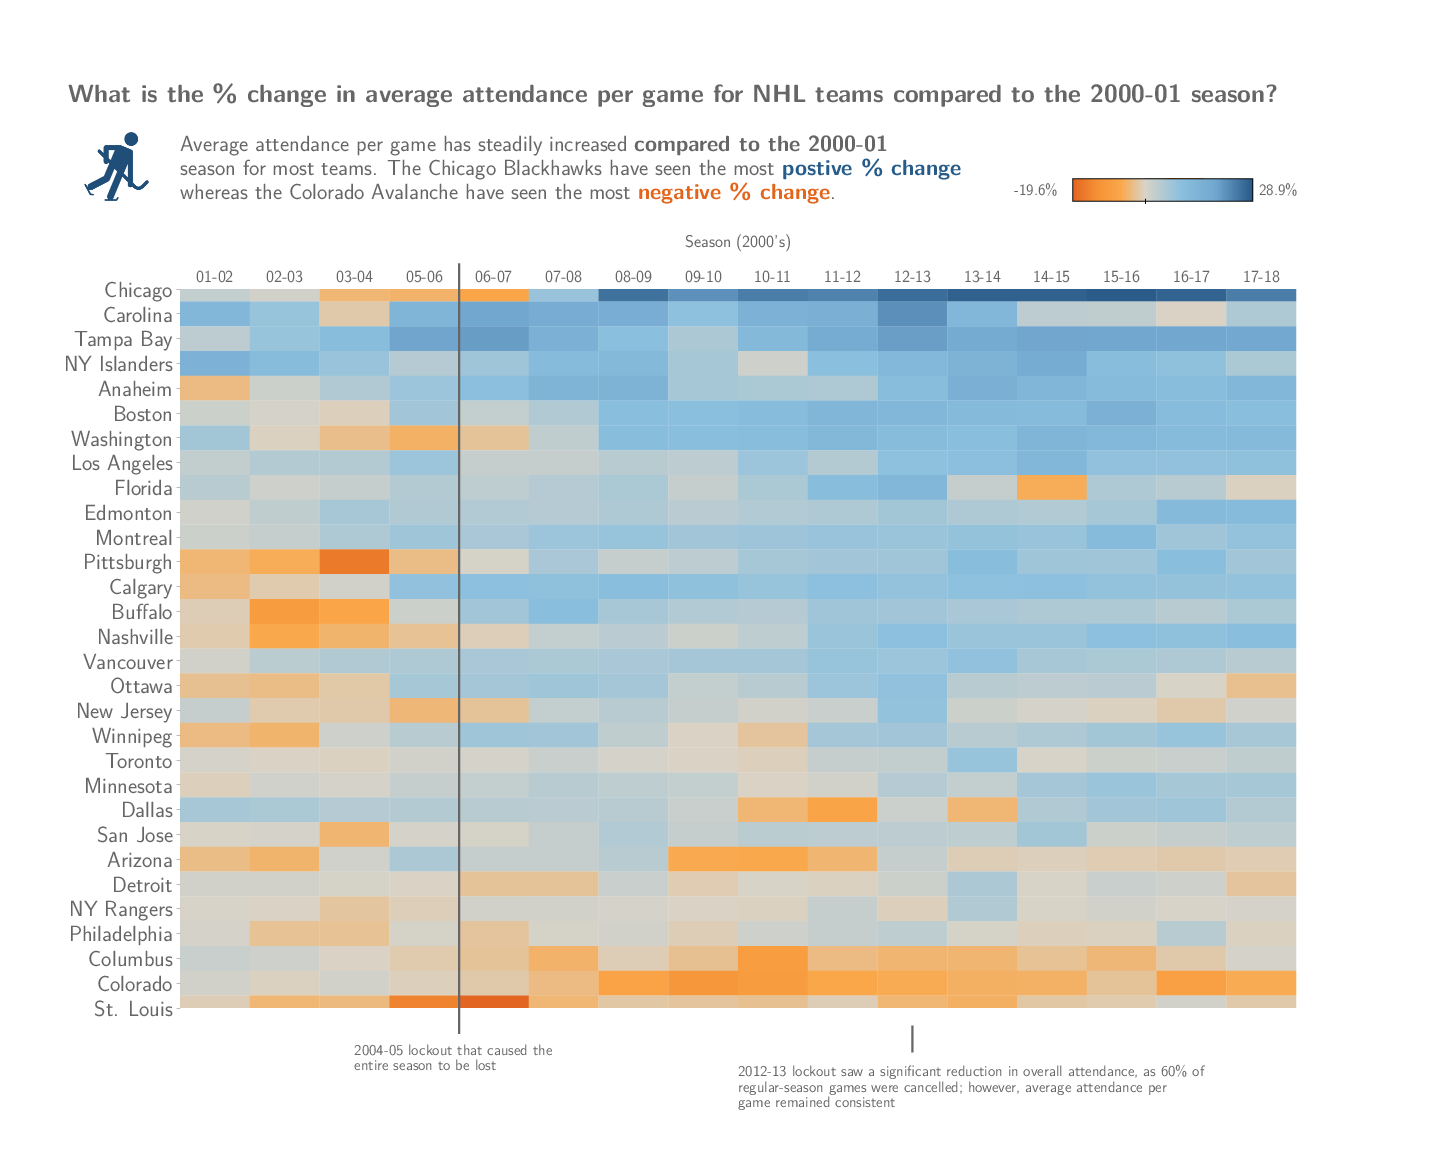

In [10]:
from wand.image import Image  

imageFromPdf = Image(filename=file_name)  
pages = len(imageFromPdf.sequence)  

image = Image(  
  width=imageFromPdf.width,  
  height=imageFromPdf.height * pages  
)  
for i in range(pages):  
  image.composite(  
  imageFromPdf.sequence[i],  
  top=imageFromPdf.height * i,  
  left=0  
)  
image.format="png"  
image